# Proyectos de Infraestructura Vial (Knapsdack)

El Ministerio de Transporte (MinTransporte) cuenta con un presupuesto de **100 millones de pesos** para ejecutar obras de infraestructura vial, con el fin de generar desarrollo en el país.

MinTransporte ha compartido con usted el archivo **“Datos.xlsx”**, el cual contiene información sobre:

- **Costo de ejecución** de cada proyecto (en millones de pesos)
- **Número de empleos generados** (en miles)
- **Ubicación geográfica** del proyecto (latitud y longitud)

El objetivo del Ministerio es **maximizar la cantidad total de empleos generados**, respetando el límite presupuestal.

Este problema se modelará como una **variación del problema de la mochila (knapsack)**, donde:
- El **presupuesto** es la capacidad de la mochila,
- Cada **proyecto** representa un ítem,
- El **costo** del proyecto es el peso del ítem,
- La **cantidad de empleos generados** es el valor del ítem.

Se utilizarán diversas **heurísticas** y técnicas de optimización para encontrar soluciones eficientes a este problema real.


## Dependencias

### Optimización y Visualización de Datos Geoespaciales

Este cuaderno utiliza herramientas de optimización lineal, generación aleatoria y visualización geoespacial para resolver el problema de obras de Min Obras.

#### Componentes principales:
- **Folium**: para la visualización de mapas interactivos.
- **PuLP**: para modelar y resolver problemas de optimización lineal.
- **Pandas y Numpy**: para manipulación y procesamiento de datos.
- **Random y time**: para generar datos de prueba y medir tiempos de ejecución.


In [1]:
# Visualización geoespacial
import folium                           # Para crear mapas interactivos
from folium.plugins import HeatMap      # Para agregar mapas de calor a los mapas de Folium

# Manipulación de datos
import pandas as pd                     # Para trabajar con estructuras de datos tipo DataFrame

# Optimización matemática
import pulp as lp                       # Para definir y resolver problemas de programación lineal

# Generación de datos aleatorios
import random                           # Para generar valores aleatorios
# random.seed(8)                        # Puedes fijar la semilla para reproducibilidad (descomentarlo si lo necesitas)

# Medición de tiempos de ejecución
import time                             # Para registrar la duración de distintos procesos

# Procesamiento numérico eficiente
import numpy as np                      # Para operaciones numéricas de alto rendimiento


## Gráfica (auxiliar)

In [2]:
def graficar_obras_mapa(
    lista_obras, 
    lat_dict, 
    lon_dict, 
    criterio_dict, 
    escala_radio=5
):
    """
    Genera un mapa interactivo con las ubicaciones de obras, representadas con círculos y un mapa de calor.

    Los círculos se escalan con base en un valor de criterio asociado a cada obra. También se genera una capa de
    mapa de calor ponderado por ese mismo criterio.

    Parámetros:
    ----------
    lista_obras : list
        Lista de identificadores de obras a graficar.

    lat_dict : dict
        Diccionario que mapea cada identificador de obra a su latitud.

    lon_dict : dict
        Diccionario que mapea cada identificador de obra a su longitud.

    criterio_dict : dict
        Diccionario que asigna a cada obra un valor numérico (por ejemplo, costo, cantidad, prioridad).

    escala_radio : float, opcional
        Factor de escala para el radio de los círculos (por defecto 5).

    Retorna:
    -------
    folium.Map
        Objeto de mapa interactivo que puede ser renderizado en un entorno como Google Colab o Jupyter Notebook.

    Nota:
    ----
    - Las obras sin coordenadas o sin valores en `criterio_dict` son ignoradas.
    - La escala del mapa se centra en el promedio de las coordenadas válidas.
    """


    # Filtrar coordenadas válidas para centrar el mapa
    latitudes = [lat_dict[i] for i in lista_obras if i in lat_dict]
    longitudes = [lon_dict[i] for i in lista_obras if i in lon_dict]
    centro_lat = sum(latitudes) / len(latitudes)
    centro_lon = sum(longitudes) / len(longitudes)

    # Inicializar el mapa centrado
    m = folium.Map(location=[centro_lat, centro_lon], zoom_start=7, tiles='CartoDB positron')

    # Agregar un círculo por cada obra válida (con coordenadas y valor de criterio)
    for i in lista_obras:
        if i in lat_dict and i in lon_dict and i in criterio_dict:
            folium.Circle(
                location=[lat_dict[i], lon_dict[i]],
                radius=criterio_dict[i] * escala_radio,  # Radio proporcional al criterio
                color='blue',
                fill=True,
                fill_opacity=0.5,
                popup=f'Obra {i}: {criterio_dict[i]}'
            ).add_to(m)

    # Generar datos para el mapa de calor (lat, lon, peso)
    heat_data = [
        [lat_dict[i], lon_dict[i], criterio_dict[i]]
        for i in lista_obras if i in lat_dict and i in lon_dict and i in criterio_dict
    ]
    HeatMap(heat_data, radius=25).add_to(m)

    return m

## Métodos de Solución

### LP: Programación Lineal

#### Optimización de Selección de Obras Públicas

Esta función implementa un modelo de optimización tipo **mochila binaria (0-1 knapsack)** que selecciona un subconjunto de obras públicas bajo una restricción de presupuesto con el objetivo de **maximizar el impacto en términos de empleos generados**.

##### Detalles:
- Cada obra tiene un costo y un impacto esperado (empleos).
- La solución óptima indica qué obras seleccionar para obtener el mayor beneficio sin superar el presupuesto.
- Utiliza la librería `PuLP` con el solver `CBC`.


#### Formulación

1. Conjuntos  
$O$: Conjunto de obras disponibles.

2. Parámetros  
$c_i$: Costo de ejecución (en millones de pesos) de la obra $i \in O$  
$e_i$: Empleos generados (en miles) por la realización de la obra $i \in O$  
$p$: Presupuesto total disponible (en millones de pesos) para ejecutar obras de infraestructura vial

3. Variables de decisión  
$$
x_i =
\begin{cases}
1, & \text{si la obra } i \in O \text{ se lleva a cabo} \\
0, & \text{de lo contrario (d.l.c.)}
\end{cases}
$$

4. Función objetivo  
$$
\text{Maximizar} \sum_{i \in O} e_i \cdot x_i
$$

5. Restricciones  

    (1) Presupuesto disponible:  
$$
\sum_{i \in O} c_i \cdot x_i \leq p
$$

    (2) Naturaleza de las variables:  
$$
x_i \in \{0, 1\}, \quad \forall i \in O
$$

    Donde (1) garantiza que no se exceda el presupuesto disponible y (2) establece la naturaleza de las variables.


In [3]:
def optimizacion_knapsack(O, c, e, p):
    """
    Resuelve un problema de optimización tipo knapsack (mochila binaria) para seleccionar obras
    que maximizan la generación de empleos, bajo una restricción presupuestaria.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de las obras.

    c : dict
        Diccionario que mapea cada obra a su costo (en millones de COP).

    e : dict
        Diccionario que mapea cada obra a la cantidad de empleos generados (en miles).

    p : float
        Presupuesto total disponible (en millones de COP).

    Retorna:
    -------
    obj_lp : float
        Valor óptimo de la función objetivo (empleos generados en miles).

    obras_selec_lp : list
        Lista de identificadores de las obras seleccionadas.

    presupuesto_usado_lp : float
        Presupuesto total utilizado por las obras seleccionadas.
    """

    # -- Definición del modelo
    model = lp.LpProblem("Obras", lp.LpMaximize)

    # -- Variables de decisión binarias: x[i] = 1 si se selecciona la obra i, 0 en caso contrario
    x = {i: lp.LpVariable(f'x_{i}', lowBound=0, cat=lp.LpBinary) for i in O}

    # -- Función objetivo: maximizar empleos generados
    model += lp.lpSum(e[i] * x[i] for i in O)

    # -- Restricciones

    # 1. Restricción de presupuesto: no se puede exceder el presupuesto disponible
    model += lp.lpSum(c[i] * x[i] for i in O) <= p

    # 2. Restricción implícita: binariedad de las variables (ya definida en la creación de x)

    # -- Resolver el modelo con el solver CBC de PuLP
    solver = lp.getSolver('PULP_CBC_CMD', msg=False)
    model.solve(solver)

    # -- Revisar y reportar el estado del optimizador
    print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')

    # -- Resultados
    obj_lp = round(lp.value(model.objective), 3)
    print(f'La cantidad de empleos generados es de: {obj_lp} (en miles).')

    obras_selec_lp = [i for i in O if x[i].varValue == 1]
    print(f'La cantidad de obras seleccionadas fue de: {len(obras_selec_lp)}.')

    presupuesto_usado_lp = round(sum(c[i] for i in O if x[i].varValue == 1), 2)
    print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado_lp}/{p}')

    return obj_lp, obras_selec_lp, presupuesto_usado_lp

### Heurísticas

#### Greedy

Esta función aplica un algoritmo **greedy (voraz)** que selecciona obras públicas ordenadas por la mayor cantidad de empleos generados, siempre que no excedan el presupuesto disponible.

##### Características:
- Prioriza obras con mayor impacto laboral.
- Más rápido que la optimización exacta (`PuLP`), aunque puede no ser óptimo.
- Útil como solución base o heurística de comparación.

In [4]:
def greedy_knapsack(O, c, e, p):
    """
    Aplica un algoritmo voraz (greedy) para seleccionar obras bajo un presupuesto,
    priorizando aquellas que generan más empleos.

    Esta aproximación no garantiza la solución óptima, pero es rápida y útil para obtener una solución inicial.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de las obras.

    c : dict
        Diccionario que asocia cada obra con su costo (en millones de COP).

    e : dict
        Diccionario que asocia cada obra con su impacto en empleos generados (en miles).

    p : float
        Presupuesto total disponible (en millones de COP).

    Retorna:
    -------
    obj_greedy : float
        Suma total de empleos generados por las obras seleccionadas (en miles).

    obras_selec_greedy : list
        Lista de obras seleccionadas por el algoritmo voraz.

    presupuesto_usado_greedy : float
        Presupuesto total utilizado por las obras seleccionadas.
    """

    # -- Inicialización
    presupuesto_actual = 0
    obras_selec_greedy = []

    # -- Ordenar las obras por impacto en empleos (de mayor a menor)
    obras_ordenadas = sorted(O, key=lambda i: e[i], reverse=True)

    # -- Selección voraz: agregar obras mientras haya presupuesto
    for i in obras_ordenadas:
        if presupuesto_actual + c[i] <= p:
            obras_selec_greedy.append(i)
            presupuesto_actual += c[i]

    # -- Resultados
    obj_greedy = round(sum(e[i] for i in obras_selec_greedy), 2)
    print(f'La cantidad de empleos generados es de: {obj_greedy} (en miles).')

    presupuesto_usado_greedy = round(presupuesto_actual, 2)
    print(f'La cantidad de obras seleccionadas fue de: {len(obras_selec_greedy)}.')
    print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado_greedy}/{p}')

    return obj_greedy, obras_selec_greedy, presupuesto_usado_greedy

#### Random

Esta función implementa una estrategia aleatoria para seleccionar obras públicas bajo un presupuesto dado. 

##### Características:
- Las obras se mezclan aleatoriamente y se seleccionan en ese orden si hay presupuesto disponible.
- Útil para benchmarking, simulaciones y evaluación de múltiples escenarios.
- Este método no garantiza una solución óptima, pero es útil para comparar con soluciones voraces o exactas.


In [5]:
def random_knapsack(O, c, e, p, report):
    """
    Aplica una heurística aleatoria para seleccionar obras bajo una restricción de presupuesto.

    Las obras se mezclan aleatoriamente y se seleccionan en ese orden mientras haya presupuesto disponible.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de las obras.

    c : dict
        Diccionario que asocia cada obra con su costo (en millones de COP).

    e : dict
        Diccionario que asocia cada obra con los empleos generados (en miles).

    p : float
        Presupuesto total disponible (en millones de COP).

    report : bool
        Si es True, imprime los resultados en consola.

    Retorna:
    -------
    obj_rand : float
        Empleos generados por las obras seleccionadas (en miles).

    obras_selec_rand : list
        Lista de obras seleccionadas aleatoriamente dentro del presupuesto.

    presupuesto_usado_rand : float
        Presupuesto total utilizado por las obras seleccionadas.
    """

    # -- Inicialización
    presupuesto_actual = 0
    obras_selec_rand = []

    # -- Mezclar aleatoriamente las obras (sin reemplazo)
    obras_random = random.sample(O, len(O))

    # -- Selección aleatoria: agregar mientras no se exceda el presupuesto
    for i in obras_random:
        if presupuesto_actual + c[i] <= p:
            obras_selec_rand.append(i)
            presupuesto_actual += c[i]

    # -- Resultados
    obj_rand = round(sum(e[i] for i in obras_selec_rand), 2)
    presupuesto_usado_rand = round(presupuesto_actual, 2)

    if report:
        print(f'La cantidad de empleos generados es de: {obj_rand} (en miles).')
        print(f'La cantidad de obras seleccionadas fue de: {len(obras_selec_rand)}.')
        print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado_rand}/{p}')

    return obj_rand, obras_selec_rand, presupuesto_usado_rand

#### Búsqueda Local con Intercambios (Swaps)

Esta función mejora una solución inicial del problema de selección de obras mediante una estrategia de **búsqueda local**. En cada iteración:

- Se elimina una obra seleccionada.
- Se prueba reemplazarla por una obra no seleccionada.
- Si el intercambio **no viola el presupuesto** y **mejora el número de empleos**, se acepta.

##### Usos:
- Refinamiento de soluciones generadas por heurísticas (`random`, `greedy`).
- Comparaciones con métodos exactos (`optimización con PuLP`).
- Evaluaciones en múltiples corridas para identificar estabilidad o mejoras promedio.

Esta estrategia es una base útil para métodos metaheurísticos más complejos como simulated annealing o tabu search.


In [6]:
def swaps_knapsack(O, c, e, p, sol_inicial, n=100, report=False):
    """
    Mejora una solución inicial del problema de la mochila mediante búsqueda local
    basada en swaps (intercambios) entre obras seleccionadas y no seleccionadas.

    En cada iteración, se intenta reemplazar una obra de la solución actual por otra fuera de ella
    si se mantiene dentro del presupuesto y mejora la cantidad total de empleos generados.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de todas las obras posibles.

    c : dict
        Diccionario con los costos (en millones de COP) de cada obra.

    e : dict
        Diccionario con los empleos generados (en miles) por cada obra.

    p : float
        Presupuesto disponible (en millones de COP).

    sol_inicial : list
        Lista de obras seleccionadas inicialmente (debe ser una solución válida).

    n : int, opcional
        Número de intentos de mejora por intercambio (default = 100).

    report : bool, opcional
        Si es True, imprime los detalles de cada mejora encontrada (default = False).

    Retorna:
    -------
    mejor_obj : float
        Total de empleos generados por la mejor solución encontrada (en miles).

    mejor_sol : list
        Lista de obras seleccionadas en la mejor solución.

    presupuesto_usado : float
        Presupuesto total utilizado por la mejor solución.
    """

    # -- Inicialización con la solución inicial
    mejor_sol = sol_inicial.copy()
    mejor_obj = sum(e[i] for i in mejor_sol)

    for inter in range(1, n + 1):

        # Elegir aleatoriamente una obra a quitar de la solución
        i = random.choice(mejor_sol)

        # Elegir aleatoriamente una obra a agregar (que no esté en la solución)
        candidatos = list(set(O) - set(mejor_sol))
        j = random.choice(candidatos)

        # Crear nueva solución intercambiando i por j
        nueva_sol = mejor_sol.copy()
        nueva_sol.remove(i)
        nueva_sol.append(j)

        # Verificar si la nueva solución respeta el presupuesto
        costo = sum(c[k] for k in nueva_sol)
        if costo <= p:

            # Verificar si mejora el objetivo (más empleos)
            obj = sum(e[k] for k in nueva_sol)
            if obj > mejor_obj:

                if report:
                    print(f'[Intento {inter}] Mejora aleatoria:')
                    print(f'  - Swap: {i} ➜ {j} (e: {e[i]} ➜ {e[j]}, c: {c[i]} ➜ {c[j]})')
                    print(f'  - Objetivo nuevo: {round(obj, 2)}')
                    print(f'  - Presupuesto: {round(costo, 2)}/{p}\n')

                # Aceptar la nueva solución como mejor
                mejor_sol, mejor_obj = nueva_sol, obj

    # -- Resultado final
    presupuesto_usado = sum(c[i] for i in mejor_sol)

    print(f'Empleos generados: {round(mejor_obj, 2)} mil')
    print(f'Obras seleccionadas: {len(mejor_sol)}')
    print(f'Presupuesto usado: {round(presupuesto_usado, 2)}/{p}')

    return mejor_obj, mejor_sol, presupuesto_usado


#### Ant Colony Optimization (ACO)

Este método aplica una metaheurística inspirada en el comportamiento de colonias de hormigas para resolver el problema de selección de obras bajo restricciones presupuestarias.

##### Características:
- Cada "hormiga" genera soluciones probabilísticas balanceando **exploración (feromonas)** y **explotación (impacto en empleos)**.
- Las mejores soluciones refuerzan el camino para futuras iteraciones.
- Capaz de explorar múltiples regiones del espacio de soluciones sin requerir una función exacta.

##### Parámetros destacados:
- `alpha`: peso de las feromonas.
- `beta`: peso del beneficio.
- `rho`: tasa de evaporación.
- `n_iter`: iteraciones totales de la colonia.

Ideal para escenarios con muchas combinaciones posibles donde los enfoques exactos son lentos o inviables.


In [7]:
def aco_knapsack(O, c, e, p, n_ants=20, n_iter=50, alpha=1, beta=2, rho=0.1, Q=1, report=False):
    """
    Resuelve el problema de la mochila (knapsack) mediante una metaheurística basada en colonia de hormigas (ACO).

    Las hormigas construyen soluciones probabilísticas considerando la cantidad de feromonas (exploración) y
    el beneficio (explotación) asociado a cada obra, buscando maximizar el número de empleos sin superar el presupuesto.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de las obras.

    c : dict
        Diccionario con los costos de cada obra (en millones de COP).

    e : dict
        Diccionario con los empleos generados por cada obra (en miles).

    p : float
        Presupuesto total disponible (en millones de COP).

    n_ants : int, opcional
        Número de hormigas por iteración (default = 20).

    n_iter : int, opcional
        Número total de iteraciones de la colonia (default = 50).

    alpha : float, opcional
        Importancia relativa de la feromona en la elección (default = 1).

    beta : float, opcional
        Importancia relativa del beneficio (empleos) en la elección (default = 2).

    rho : float, opcional
        Tasa de evaporación de feromonas (entre 0 y 1, default = 0.1).

    Q : float, opcional
        Factor de intensidad del refuerzo de feromonas (default = 1).

    report : bool, opcional
        Si es True, imprime el progreso iterativo y la mejor solución encontrada (default = False).

    Retorna:
    -------
    best_obj : float
        Total de empleos generados por la mejor solución (en miles).

    best_solution_ids : list
        Lista de identificadores de obras seleccionadas en la mejor solución.

    presupuesto_usado : float
        Presupuesto total utilizado por la mejor solución (en millones de COP).
    """

    n = len(O)
    c = np.array([c[i] for i in O])
    e = np.array([e[i] for i in O])
    pheromone = np.ones(n)  # Inicialización de feromonas
    eta = e.copy()          # Beneficio como heurística

    best_solution = []
    best_obj = 0

    for iteration in range(n_iter):
        all_solutions = []

        for _ in range(n_ants):
            presupuesto_actual = 0
            seleccionadas = []
            indices = list(range(n))
            random.shuffle(indices)  # Diversificación

            while indices:
                idx_array = np.array(indices)
                viables = c[idx_array] + presupuesto_actual <= p

                if not np.any(viables):
                    break

                viables_idx = idx_array[viables]
                pheromone_viables = pheromone[viables_idx]
                eta_viables = eta[viables_idx]

                valor = (pheromone_viables ** alpha) * (eta_viables ** beta)
                if valor.sum() == 0:
                    break

                probs_norm = valor / valor.sum()
                i = np.random.choice(viables_idx, p=probs_norm)

                seleccionadas.append(i)
                presupuesto_actual += c[i]
                indices.remove(i)

            # Evaluar solución de la hormiga
            obj = e[seleccionadas].sum()
            all_solutions.append((seleccionadas, obj))

            if obj > best_obj:
                best_solution = seleccionadas
                best_obj = obj

        # Evaporación de feromonas
        pheromone *= (1 - rho)

        # Reforzamiento con soluciones generadas
        for seleccionadas, obj in all_solutions:
            costo_total = c[seleccionadas].sum()
            if costo_total > 0:
                pheromone[seleccionadas] += Q * (obj / costo_total)

        if report:
            print(f"[Iteración {iteration + 1}] Mejor objetivo: {round(best_obj, 2)}")

    presupuesto_usado = round(c[best_solution].sum(), 2)

    print(f'La cantidad de empleos generados es de: {round(best_obj, 2)} (en miles).')
    print(f'La cantidad de obras seleccionadas fue de: {len(best_solution)}.')
    print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado}/{p}')

    return best_obj, [O[i] for i in best_solution], presupuesto_usado

### DP: Programación Dinamica

#### Traidicional

Esta función implementa una solución exacta para el problema de selección de obras mediante **programación dinámica (DP)**.

##### Características:
- Convierte el problema a valores enteros para hacerlo compatible con DP clásica.
- Encuentra la **solución óptima global** sin necesidad de heurísticas.
- Útil cuando el presupuesto y los costos no son excesivamente grandes (por límites de memoria).

##### Consideraciones:
- El parámetro `factor` controla la precisión de conversión (e.g., `factor=1000` considera hasta 3 decimales).
- Requiere más memoria que métodos heurísticos, pero garantiza optimalidad.


In [8]:
def dp_knapsack(O, c, e, p, factor=1000):
    """
    Resuelve el problema de la mochila usando programación dinámica (DP),
    entregando una solución exacta bajo restricción presupuestaria.

    Esta versión convierte los costos y presupuesto a enteros usando un factor de escalamiento
    para hacerlos compatibles con DP clásica basada en pesos discretos.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de obras.

    c : dict
        Diccionario con los costos de cada obra (en millones de COP).

    e : dict
        Diccionario con los empleos generados por cada obra (en miles).

    p : float
        Presupuesto total disponible (en millones de COP).

    factor : int, opcional
        Factor de escalamiento para convertir costos y presupuesto a enteros (default = 1000).
        Por ejemplo, factor=1000 permite trabajar con tres decimales.

    Retorna:
    -------
    valor_optimo : float
        Máximo número de empleos generados (en miles).

    obras_seleccionadas : list
        Lista de identificadores de las obras seleccionadas.

    presupuesto_usado : float
        Presupuesto total utilizado por la solución óptima (en millones de COP).
    """

    # -- Preparación de datos
    n = len(O)
    c_int = [int(round(c[i] * factor)) for i in O]  # Escalar costos
    e_int = [e[i] for i in O]                       # Beneficios (empleos)
    p_int = int(round(p * factor))                  # Escalar presupuesto

    # -- Inicializar tabla de DP
    dp = [[0] * (p_int + 1) for _ in range(n + 1)]

    # -- Llenar tabla DP
    for i in range(1, n + 1):
        for w in range(p_int + 1):

            if c_int[i - 1] <= w:
                # Podemos incluir la obra i-1
                dp[i][w] = max(dp[i - 1][w], e_int[i - 1] + dp[i - 1][w - c_int[i - 1]])
                
            else:
                # No podemos incluirla: heredar valor anterior
                dp[i][w] = dp[i - 1][w]

    valor_optimo = dp[n][p_int]

    # -- Reconstruir la solución óptima desde la tabla
    w = p_int
    obras_seleccionadas = []

    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            obra_id = O[i - 1]
            obras_seleccionadas.append(obra_id)
            w -= c_int[i - 1]

    # -- Calcular presupuesto usado en escala original
    presupuesto_usado = round(sum(c[i] for i in obras_seleccionadas), 2)

    # -- Mostrar resultados
    print(f'La cantidad de empleos generados es de: {round(valor_optimo, 2)} (en miles).')
    print(f'La cantidad de obras seleccionadas fue de: {len(obras_seleccionadas)}.')
    print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado}/{p}')

    return valor_optimo, obras_seleccionadas, presupuesto_usado

#### Eficiente

Esta función utiliza una versión optimizada de programación dinámica para resolver el problema de la mochila con precisión exacta y eficiencia en memoria.

##### Mejoras frente a la versión clásica:
- Se utiliza un solo vector (`1D DP`) en lugar de una matriz completa, reduciendo el uso de memoria.
- Se registra únicamente si una obra fue usada en cada subpresupuesto.
- El tiempo de ejecución se mantiene con mejor aprovechamiento de estructuras `numpy`.

##### Consideraciones:
- Ideal para conjuntos de obras moderados (decenas a centenas), y presupuestos que puedan escalarse a enteros sin explotar la memoria.
- Garantiza una solución óptima.

In [9]:
def dp_knapsack(O, c, e, p, factor=1000):
    """
    Resuelve el problema de la mochila (knapsack) usando una implementación eficiente de programación dinámica.

    Se usa una sola dimensión (`1D`) para la tabla de DP y un arreglo booleano para rastrear las decisiones,
    permitiendo reconstruir las obras seleccionadas sin necesidad de guardar toda la tabla original.

    Parámetros:
    ----------
    O : list
        Lista de identificadores de obras.

    c : dict
        Diccionario con los costos de cada obra (en millones de COP).

    e : dict
        Diccionario con los empleos generados por cada obra (en miles).

    p : float
        Presupuesto disponible (en millones de COP).

    factor : int, opcional
        Factor para escalar los costos y presupuesto a enteros (default = 1000).

    Retorna:
    -------
    valor_optimo : float
        Total de empleos generados por la solución óptima (en miles).

    obras_seleccionadas : list
        Lista de identificadores de obras seleccionadas.

    presupuesto_usado : float
        Presupuesto total utilizado por las obras seleccionadas (en millones de COP).
    """

    # -- Preparar datos --
    n = len(O)
    c_int = (np.round(np.array([c[i] for i in O]) * factor)).astype(int)  # Costos escalados
    e_arr = np.array([e[i] for i in O], dtype=np.float64)                 # Empleos
    p_int = int(round(p * factor))                                        # Presupuesto escalado

    # -- Inicializar estructuras --
    dp = np.zeros(p_int + 1, dtype=np.float64)                            # Vector DP de 1D
    decisions = np.zeros((n, p_int + 1), dtype=bool)                      # Registro de decisiones

    # -- Programación dinámica --
    for i in range(n):
        cost, emp = c_int[i], e_arr[i]

        if cost <= p_int:
            dp_prev = dp.copy()
            candidate = dp_prev[:-cost] + emp                             # Opción de incluir la obra
            dp[cost:] = np.maximum(dp_prev[cost:], candidate)
            decisions[i, cost:] = dp[cost:] != dp_prev[cost:]

    # -- Obtener valor óptimo --
    valor_optimo = float(dp[p_int])

    # -- Reconstruir solución mediante backtracking --
    w = p_int
    obras_seleccionadas = []

    for i in range(n - 1, -1, -1):  # De atrás hacia adelante
        cost = c_int[i]
        if w >= cost and decisions[i, w]:
            obras_seleccionadas.append(O[i])
            w -= cost

    presupuesto_usado = round(sum(c[i] for i in obras_seleccionadas), 2)

    # -- Reporte final --
    print(f'La cantidad de empleos generados es de: {round(valor_optimo, 2)} (en miles).')
    print(f'La cantidad de obras seleccionadas fue de: {len(obras_seleccionadas)}.')
    print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado}/{p}')

    return valor_optimo, obras_seleccionadas, presupuesto_usado


## Datos

### Originales

In [10]:
# -- Leer Datos
obras = pd.read_excel("Datos.xlsx", index_col=0)
obras

,Costo de ejecución (en millones de pesos),# de empleos generados (en miles),Latitud,Longitud
Obra,,,,
1,2.1,1.9,4.710897,-74.085441
2,2.5,2.4,4.600873,-74.100913
3,0.8,1.6,4.832276,-74.081035
4,1.5,1.0,4.774272,-74.120945
5,2.3,1.3,4.699947,-74.178032
...,...,...,...,...
96,0.3,0.2,4.560021,-74.140077
97,2.8,0.5,4.793577,-74.067155
98,1.4,2.8,4.606117,-74.056254


### Generación Sintética de Datos de Obras Públicas

Esta función genera un conjunto artificial de datos para simular un portafolio de obras públicas, distribuidas geográficamente en cinco ciudades de Colombia:

- **Bogotá**
- **Medellín**
- **Cartagena**
- **Barranquilla**
- **Cali**

#### Atributos generados:
- **Ciudad**: selección aleatoria entre las 5 ciudades.
- **Costo de ejecución**: entre 0.001 y 10 millones de pesos.
- **# de empleos generados**: entre 0.01 y 15 mil.
- **Latitud y longitud**: aleatoria dentro de un rango representativo por ciudad.


In [11]:
# -- Rango de coordenadas por ciudad --
ciudades = {
    "Bogotá":      {"lat": (4.5, 4.85), "lon": (-74.2, -74.0)},
    "Medellín":    {"lat": (6.15, 6.4), "lon": (-75.65, -75.5)},
    "Cartagena":   {"lat": (10.3, 10.5), "lon": (-75.6, -75.4)},
    "Barranquilla":{"lat": (10.9, 11.1), "lon": (-74.9, -74.7)},
    "Cali":        {"lat": (3.3, 3.6), "lon": (-76.6, -76.4)}
}

def generar_datos(num_registros: int):
    """
    Genera un conjunto sintético de datos de obras públicas con ubicación geográfica y atributos económicos.

    Cada obra es asignada aleatoriamente a una ciudad colombiana, dentro de un rango de coordenadas específicas,
    y se le asocia un costo de ejecución y una estimación de empleos generados.

    Parámetros:
    ----------
    num_registros : int
        Número total de registros (obras) a generar.

    Retorna:
    -------
    df : pd.DataFrame
        DataFrame con las siguientes columnas:
        - 'Ciudad': nombre de la ciudad.
        - 'Costo de ejecución (en millones de pesos)': valor flotante entre 0.001 y 10.
        - '# de empleos generados (en miles)': valor flotante entre 0.01 y 15.
        - 'Latitud': coordenada aleatoria dentro del rango de la ciudad.
        - 'Longitud': coordenada aleatoria dentro del rango de la ciudad.
    """


    datos = []

    for _ in range(num_registros):
        ciudad = random.choice(list(ciudades.keys()))               # Selección aleatoria de ciudad
        lat_range = ciudades[ciudad]["lat"]
        lon_range = ciudades[ciudad]["lon"]

        costo = round(random.uniform(0.001, 10), 3)                 # Costo aleatorio (0.001 a 10 millones)
        empleo = round(random.uniform(0.01, 15), 2)                 # Empleos aleatorios (0.01 a 15 mil)
        lat = round(random.uniform(*lat_range), 6)                  # Latitud aleatoria dentro de la ciudad
        lon = round(random.uniform(*lon_range), 6)                  # Longitud aleatoria dentro de la ciudad

        datos.append({
            "Ciudad": ciudad,
            "Costo de ejecución (en millones de pesos)": costo,
            "# de empleos generados (en miles)": empleo,
            "Latitud": lat,
            "Longitud": lon
        })

    df = pd.DataFrame(datos)
    return df

obras = generar_datos(500)
obras


,Ciudad,Costo de ejecución (en millones de pesos),# de empleos generados (en miles),Latitud,Longitud
0,Barranquilla,2.851,9.16,11.019284,-74.819383
1,Bogotá,8.312,10.86,4.776154,-74.186015
2,Cali,9.040,10.19,3.504265,-76.427529
3,Medellín,8.488,1.12,6.327625,-75.582351
4,Medellín,1.107,7.39,6.216528,-75.600526
...,...,...,...,...,...
495,Medellín,3.194,3.41,6.287828,-75.635736
496,Cali,8.177,5.29,3.317301,-76.476875
497,Cali,0.816,1.53,3.426224,-76.497472
498,Medellín,9.301,14.82,6.392171,-75.604571


### Parámetros

In [12]:
# -- Conjuntos --
O = list(obras.index)
# Lista de identificadores de obras (índices del DataFrame)

# -- Parámetros --
c = dict(obras['Costo de ejecución (en millones de pesos)'].squeeze())
# Diccionario con el costo de cada obra, en millones de COP

e = dict(obras['# de empleos generados (en miles)'].squeeze())
# Diccionario con el número de empleos generados por cada obra (en miles)

lat = dict(obras['Latitud'].squeeze())
# Diccionario con la latitud de cada obra (para visualización geográfica)

log = dict(obras['Longitud'].squeeze())
# Diccionario con la longitud de cada obra (para visualización geográfica)

p = max(len(O), 100)
# Presupuesto disponible: se define como el máximo entre la cantidad de obras o 100 millones (flexible)

## Resultados

In [13]:
resultados = []
# Almacenar los resultados

#### LP

In [14]:
# -- Medir tiempo de ejecución del método de optimización lineal (LP) --
start = time.perf_counter()

# Ejecutar el modelo exacto con PuLP
obj_lp, obras_selec_lp, presupuesto_usado_lp = optimizacion_knapsack(O, c, e, p)

end = time.perf_counter()
print(f"Tiempo (s): {end - start:.8f}")

# -- Almacenar resultados en lista de reportes --
resultados.append({
    "Método": "LP",                                   # Identificador del método
    "Empleos generados": obj_lp,                      # Objetivo alcanzado
    "Obras seleccionadas": len(obras_selec_lp),       # Número de obras seleccionadas
    "Presupuesto usado": presupuesto_usado_lp,        # Presupuesto efectivamente utilizado
    "Tiempo (s)": end - start                          # Tiempo total de ejecución
})

El optimizador llegó a una solución: Optimal.
La cantidad de empleos generados es de: 1832.41 (en miles).
La cantidad de obras seleccionadas fue de: 185.
El presupuesto usado fue (COP Millones): 499.95/500
Tiempo (s): 0.08684450


#### Greedy

In [15]:
# -- Medir tiempo de ejecución del algoritmo voraz (greedy) --
start = time.perf_counter()

# Ejecutar algoritmo greedy: selecciona obras que generan más empleos primero
obj_greedy, obras_selec_greedy, presupuesto_usado_greedy = greedy_knapsack(O, c, e, p)

end = time.perf_counter()
print(f"Tiempo (s): {end - start:.8f}")

# -- Almacenar resultados --
resultados.append({
    "Método": "Greedy",                                     # Nombre del enfoque
    "Empleos generados": obj_greedy,                        # Total de empleos alcanzado
    "Obras seleccionadas": len(obras_selec_greedy),         # Cantidad de obras elegidas
    "Presupuesto usado": presupuesto_usado_greedy,          # Recursos utilizados
    "Tiempo (s)": end - start                               # Tiempo de ejecución en segundos
})

La cantidad de empleos generados es de: 1332.89 (en miles).
La cantidad de obras seleccionadas fue de: 101.
El presupuesto usado fue (COP Millones): 499.96/500
Tiempo (s): 0.00019296


#### Random

In [16]:
# -- Configuración --
n_iteraciones = 1000                         # Número total de iteraciones (repeticiones aleatorias)
mejor_obj = -1                               # Mejores resultados observados
mejor_obras = None
mejor_presupuesto = 0
mejor_tiempo = 0

start_global = time.perf_counter()          # Medir tiempo total del experimento

# -- Ejecutar múltiples soluciones aleatorias --
for _ in range(n_iteraciones):
    start = time.perf_counter()
    obj_rand, obras_selec_rand, presupuesto_usado_rand = random_knapsack(O, c, e, p, report=False)
    end = time.perf_counter()

    # Guardar la mejor solución observada
    if obj_rand > mejor_obj:
        mejor_obj = obj_rand
        mejor_obras = obras_selec_rand
        mejor_presupuesto = presupuesto_usado_rand
        mejor_tiempo = end - start

end_global = time.perf_counter()

# -- Reporte por consola --
print(f'La cantidad de empleos generados es de: {mejor_obj} (en miles).')
print(f'La cantidad de obras seleccionadas fue de: {len(mejor_obras)}.')
print(f'El presupuesto usado fue (COP Millones): {mejor_presupuesto}/{p}')
print(f"Tiempo (s): {mejor_tiempo:.8f}")

# -- Guardar resultados --
resultados.append({
    "Método": "Random",
    "Empleos generados": mejor_obj,
    "Obras seleccionadas": len(mejor_obras),
    "Presupuesto usado": mejor_presupuesto,
    "Tiempo (s)": mejor_tiempo
})

La cantidad de empleos generados es de: 890.42 (en miles).
La cantidad de obras seleccionadas fue de: 114.
El presupuesto usado fue (COP Millones): 499.98/500
Tiempo (s): 0.00011008


#### Random Swaps

In [17]:
# -- Usar como punto de partida la mejor solución aleatoria --
sol_inicial = obras_selec_rand

# -- Medir tiempo de ejecución --
start = time.perf_counter()

# -- Ejecutar búsqueda local con swaps: intenta mejorar 10,000 veces
obj_rand_swaps, obras_selec_rand_swaps, presupuesto_usado_rand_swaps = swaps_knapsack(
    O, c, e, p, sol_inicial, n=10000, report=True
)

end = time.perf_counter()
print(f"Tiempo (s): {end - start:.8f}")

# -- Almacenar resultados --
resultados.append({
    "Método": "Random + Swaps",                              # Método híbrido
    "Empleos generados": obj_rand_swaps,                     # Objetivo mejorado
    "Obras seleccionadas": len(obras_selec_rand_swaps),      # Cantidad de obras
    "Presupuesto usado": presupuesto_usado_rand_swaps,       # Recursos utilizados
    "Tiempo (s)": end - start                                # Tiempo de ejecución
})

[Intento 5] Mejora aleatoria:
  - Swap: 150 ➜ 245 (e: 0.89 ➜ 7.31, c: 2.91 ➜ 1.532)
  - Objetivo nuevo: 744.59
  - Presupuesto: 498.58/500

[Intento 15] Mejora aleatoria:
  - Swap: 139 ➜ 228 (e: 4.3 ➜ 6.53, c: 9.816 ➜ 1.233)
  - Objetivo nuevo: 746.82
  - Presupuesto: 490.0/500

[Intento 18] Mejora aleatoria:
  - Swap: 296 ➜ 252 (e: 9.43 ➜ 13.07, c: 9.455 ➜ 0.08)
  - Objetivo nuevo: 750.46
  - Presupuesto: 480.62/500

[Intento 22] Mejora aleatoria:
  - Swap: 208 ➜ 128 (e: 0.69 ➜ 7.49, c: 7.859 ➜ 6.021)
  - Objetivo nuevo: 757.26
  - Presupuesto: 478.79/500

[Intento 25] Mejora aleatoria:
  - Swap: 322 ➜ 473 (e: 6.21 ➜ 13.56, c: 5.329 ➜ 9.245)
  - Objetivo nuevo: 764.61
  - Presupuesto: 482.7/500

[Intento 28] Mejora aleatoria:
  - Swap: 226 ➜ 493 (e: 5.02 ➜ 12.22, c: 3.594 ➜ 8.188)
  - Objetivo nuevo: 771.81
  - Presupuesto: 487.3/500

[Intento 33] Mejora aleatoria:
  - Swap: 304 ➜ 125 (e: 13.87 ➜ 14.3, c: 6.851 ➜ 8.375)
  - Objetivo nuevo: 772.24
  - Presupuesto: 488.82/500

[Intento 

#### ACO

In [18]:
# -- Medir tiempo de ejecución de ACO --
start = time.perf_counter()

# -- Ejecutar colonia de hormigas con parámetros personalizados
obj_aco, obras_selec_aco, presupuesto_usado_aco = aco_knapsack(
    O, c, e, p,
    n_ants=15,             # Número de hormigas por iteración
    n_iter=50,             # Número total de iteraciones
    alpha=1.5,             # Importancia de la feromona
    beta=3,                # Importancia del beneficio (empleos)
    rho=0.1,               # Tasa de evaporación
    Q=1.2,                  # Intensidad de depósito
    report=True            # Mostrar mejoras por iteración
)

end = time.perf_counter()
print(f"Tiempo (s): {end - start:.8f}")

# -- Almacenar resultados --
resultados.append({
    "Método": "ACO",
    "Empleos generados": obj_aco,
    "Obras seleccionadas": len(obras_selec_aco),
    "Presupuesto usado": presupuesto_usado_aco,
    "Tiempo (s)": end - start
})

[Iteración 1] Mejor objetivo: 1217.51
[Iteración 2] Mejor objetivo: 1312.85
[Iteración 3] Mejor objetivo: 1335.91
[Iteración 4] Mejor objetivo: 1365.52
[Iteración 5] Mejor objetivo: 1385.24
[Iteración 6] Mejor objetivo: 1385.24
[Iteración 7] Mejor objetivo: 1385.24
[Iteración 8] Mejor objetivo: 1385.24
[Iteración 9] Mejor objetivo: 1385.24
[Iteración 10] Mejor objetivo: 1385.24
[Iteración 11] Mejor objetivo: 1385.24
[Iteración 12] Mejor objetivo: 1385.24
[Iteración 13] Mejor objetivo: 1392.88
[Iteración 14] Mejor objetivo: 1437.48
[Iteración 15] Mejor objetivo: 1437.48
[Iteración 16] Mejor objetivo: 1437.48
[Iteración 17] Mejor objetivo: 1437.48
[Iteración 18] Mejor objetivo: 1437.48
[Iteración 19] Mejor objetivo: 1437.48
[Iteración 20] Mejor objetivo: 1437.48
[Iteración 21] Mejor objetivo: 1437.48
[Iteración 22] Mejor objetivo: 1437.48
[Iteración 23] Mejor objetivo: 1437.48
[Iteración 24] Mejor objetivo: 1437.48
[Iteración 25] Mejor objetivo: 1437.48
[Iteración 26] Mejor objetivo: 143

#### DP

In [19]:
# -- Medir tiempo de ejecución de la programación dinámica --
start = time.perf_counter()

# -- Ejecutar algoritmo exacto con DP
obj_dp, obras_selec_dp, presupuesto_usado_dp = dp_knapsack(O, c, e, p, factor=1000)

end = time.perf_counter()
print(f"Tiempo (s): {end - start:.8f}")

# -- Almacenar resultados --
resultados.append({
    "Método": "DP",                                           # Método exacto
    "Empleos generados": obj_dp,                              # Total de empleos alcanzado
    "Obras seleccionadas": len(obras_selec_dp),               # Número de obras seleccionadas
    "Presupuesto usado": presupuesto_usado_dp,                # Presupuesto efectivamente utilizado
    "Tiempo (s)": end - start                                 # Tiempo de ejecución
})


La cantidad de empleos generados es de: 1832.41 (en miles).
La cantidad de obras seleccionadas fue de: 185.
El presupuesto usado fue (COP Millones): 499.95/500
Tiempo (s): 0.51407808


#### Comparación

In [20]:
# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice para facilitar la comparación --
df_resultados.set_index("Método", inplace=True)

# -- Visualizar resultados --
df_resultados

,Empleos generados,Obras seleccionadas,Presupuesto usado,Tiempo (s)
Método,,,,
LP,1832.41,185,499.950,0.086845
Greedy,1332.89,101,499.960,0.000193
Random,890.42,114,499.980,0.000110
Random + Swaps,1341.34,101,499.967,0.164664
ACO,1458.64,116,499.700,2.883179
DP,1832.41,185,499.950,0.514078


In [24]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

,Empleos generados GAP (%),Obras seleccionadas GAP (%),Presupuesto usado GAP (%),Tiempo (s) (x veces LP)
Método,,,,
LP,0.000,0.000,0.000,1.0000
Greedy,-27.260,-45.405,0.002,0.0022
Random,-51.407,-38.378,0.006,0.0013
Random + Swaps,-26.799,-45.405,0.003,1.8961
ACO,-20.398,-37.297,-0.050,33.1993
DP,0.000,0.000,0.000,5.9195


## Visual

In [ ]:
# -- Seleccionar el conjunto de obras a visualizar --
ver = obras_selec_lp  # Puedes cambiarlo por otro método, por ejemplo: obras_selec_greedy, obras_selec_aco, etc.

# -- Graficar las obras en un mapa usando coordenadas y empleos --
graficar_obras_mapa(ver, lat, log, e)

## Programación Dinámica en la Mochila 0-1: Aplicación de la Ecuación de Bellman

En el problema de la mochila (0-1 knapsack), usamos **programación dinámica** para construir una solución óptima paso a paso.  
Se usa la **ecuación de Bellman**, que define cómo tomar decisiones óptimas acumuladas:

### Para cada obra `i` y presupuesto `w`:

$$
\text{dp}[i][w] = 
\begin{cases}
\max\left(\text{dp}[i-1][w],\ e[i] + \text{dp}[i-1][w - c[i]]\right), & \text{si } c[i] \leq w \\\\
\text{dp}[i-1][w], & \text{si } c[i] > w
\end{cases}
$$

Donde:
- $dp[i][w]$: máximo número de empleos posibles usando las primeras $i$ obras y un presupuesto total $w$
- $e[i]$: número de empleos que genera la obra $i$
- $c[i]$: costo de la obra $i$

Dos casos posibles:

1. **Si la obra $i$ cabe en el presupuesto ($c[i] \leq w$)**:
   - Evaluamos **dos opciones**:
     - **No incluir** la obra $i$: mantenemos lo que ya se podía lograr con $i-1$ obras → $dp[i-1][w]$
     - **Incluirla**: sumamos sus empleos a lo que se podía hacer con el presupuesto restante → $e[i] + dp[i-1][w - c[i]]$
   - Tomamos la mejor opción usando `max`.

2. **Si la obra $i$ no cabe ($c[i] > w$)**:
   - No se puede incluir, así que la mejor opción es la que teníamos sin ella: $dp[i-1][w]$



### Ejemplo con 4 obras y presupuesto 5:

| Obra | Costo (millones) | Empleos (miles) |
|------|------------------|-----------------|
| A    | 2                | 40              |
| B    | 3                | 50              |
| C    | 4                | 65              |
| D    | 5                | 80              |

Presupuesto total: `p = 5` millones

### Construcción de la tabla `dp[i][w]` paso a paso

| i / w         | 0 | 1 | 2  | 3  | 4  | 5  |
|---------------|---|---|----|----|----|----|
| 0 obras       | 0 | 0 | 0  | 0  | 0  | 0  |
| 1 (A)         | 0 | 0 | 40 | 40 | 40 | 40 |
| 2 (B)         | 0 | 0 | 40 | 50 | 50 | 90 |
| 3 (C)         | 0 | 0 | 40 | 50 | 65 | 90 |
| 4 (D)         | 0 | 0 | 40 | 50 | 65 | 90 |

#### ¿Cómo leer esta tabla?

- **Fila 0**: sin obras disponibles, no se puede generar empleos.
- **Fila 1 (A)**: si tengo al menos 2 millones, puedo incluir A y obtener 40 empleos.
- **Fila 2 (B)**:
  - En `w = 3`, puedo elegir entre:  
    - no tomar nada → 40 (de A),  
    - o tomar B → 50 (mejor).
  - En `w = 5`, puedo tomar A + B → 90 empleos.
- **Fila 3 (C)**:
  - En `w = 4`, C es mejor que A o B solos: 65 > 50.
  - En `w = 5`, ya A + B (90) sigue siendo mejor que cualquier otra combinación.
- **Fila 4 (D)**:
  - Solo cabe en `w = 5` y da 80, pero A + B sigue siendo mejor (90), así que no mejora.

### Solución final

- **Empleos generados**: `90` (óptimo)
- **Obras seleccionadas**: `A` y `B`
- **Presupuesto usado**: `5 millones`

Esta solución fue encontrada **sin necesidad de probar todas las combinaciones**, gracias a la eficiencia de la **ecuación de Bellman**.


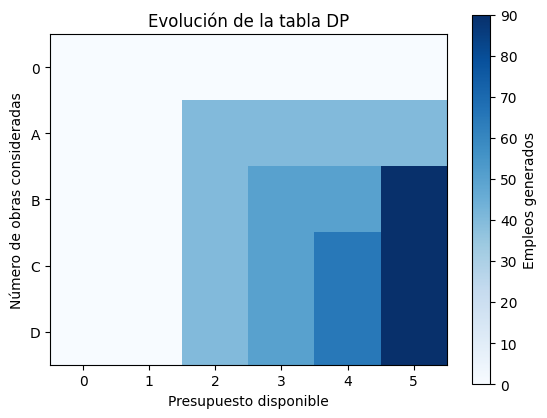

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Simulación manual para el ejemplo anterior
dp_matrix = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 40, 40, 40, 40],
    [0, 0, 40, 50, 50, 90],
    [0, 0, 40, 50, 65, 90],
    [0, 0, 40, 50, 65, 90]
])

plt.imshow(dp_matrix, cmap="Blues", interpolation='nearest')

plt.colorbar(label="Empleos generados")
plt.xlabel("Presupuesto disponible")
plt.ylabel("Número de obras consideradas")
plt.title("Evolución de la tabla DP")

plt.xticks(ticks=range(6), labels=[0, 1, 2, 3, 4, 5])
plt.yticks(ticks=range(5), labels=["0", "A", "B", "C", "D"])
plt.show()
